In [5]:
# Import dependencies 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3 as sql
from pathlib import Path


# Configuration
#"db-path": Path(".\dbs\test_1000cids.db")
CONFIG = {"db-path": Path("../dbs/test_1000cids.db")}

plt.rcParams["figure.figsize"] = (10,6)

# connect to the local DB
db_con = sql.connect(CONFIG["db-path"])

In [6]:
# Read the Cids from the db
cids = pd.read_sql_query("select * from cid_info order by id;", db_con)

# Read the Peers from the db
peers = pd.read_sql_query("select * from peer_info order by id;", db_con)

# Read the Fetch results from the db
fetchs = pd.read_sql_query("select cid from fetch_results order by id;", db_con)

# Read the Ping results from the db
pings = pd.read_sql_query("select * from ping_results order by id;", db_con)


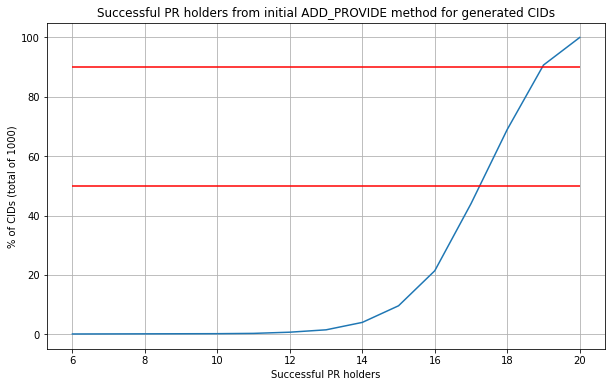

In [7]:
# Get the number of successfull ADD_PR 
pobj = pd.read_sql_query("select success_att, count(success_att) from fetch_results where fetch_round=0 group by success_att order by success_att ASC", db_con)

# init empty array for aggregation column 
agg_array = []
for i, row in pobj.iterrows():
    agg_array.append(0)
pobj["aggregation"] = agg_array

aggregation = 0
# get the aggregation of the success ratio 
for i, row in pobj.iterrows():
    aggregation += row['count(success_att)']
    pobj.at[i,'aggregation'] = aggregation
    
# get the percentage of success attempts 
pobj["% cids"] = (pobj["aggregation"] * 100) / aggregation

plt.plot(pobj["success_att"],pobj["% cids"])
plt.title("Successful PR holders from initial ADD_PROVIDE method for generated CIDs")
plt.xlabel("Successful PR holders")
plt.ylabel(f"% of CIDs (total of {aggregation})")
plt.hlines(y=[50,90], xmin=pobj.iloc[0]['success_att'], xmax=pobj.iloc[len(pobj)-1]['success_att'], color='r', linestyle='-', label='50%')
plt.grid()

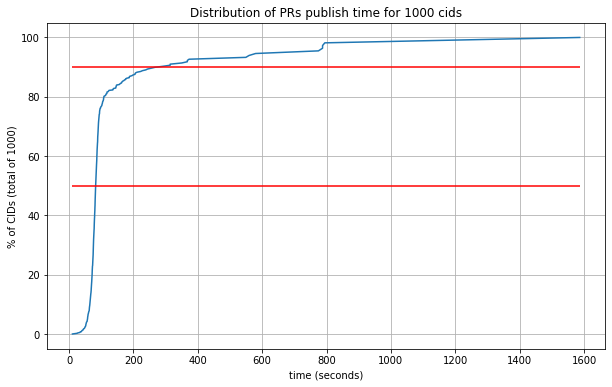

In [8]:
# Get the time to the IPFS DHT Provide method
pobj = pd.read_sql_query("select provide_time from cid_info order by provide_time ASC", db_con)

# init empty array for aggregation column 
agg_array = []
for i, row in pobj.iterrows():
    agg_array.append(0)
pobj["aggregation"] = agg_array

aggregation = 0
# get the aggregation of the success ratio 
for i, row in pobj.iterrows():
    aggregation += row['provide_time']
    pobj.at[i,'aggregation'] = aggregation
    
# get the percentage of success attempts 
pobj["% cids"] = (pobj["aggregation"] * 100) / aggregation
pobj["provide_time"] = pobj["provide_time"] / 1000 # convert to seconds

plt.plot(pobj["provide_time"],pobj["% cids"])
plt.title(f'Distribution of PRs publish time for {len(pobj)} cids')
plt.xlabel("time (seconds)")
plt.ylabel(f"% of CIDs (total of {len(pobj)})")
plt.hlines(y=[50, 90], xmin=pobj.iloc[0]['provide_time'], xmax=pobj.iloc[len(pobj)-1]['provide_time'], color='r', linestyle='-', label='50%')
plt.grid()

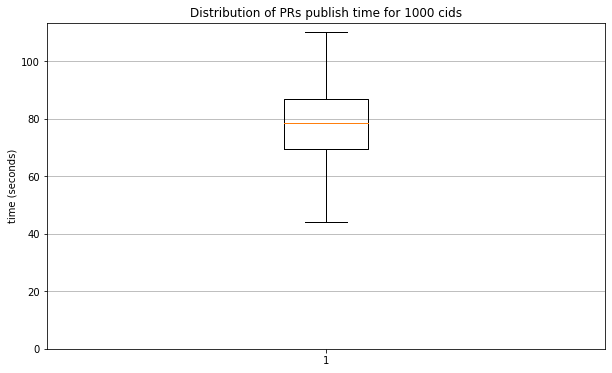

In [12]:
# Quartiles of time to execute IPFS DHT Provide method
pobj = pd.read_sql_query("select provide_time from cid_info order by provide_time ASC", db_con)

pobj["provide_time"] /= 1000 # convert to secods 

fig, ax = plt.subplots()
ax.boxplot(pobj["provide_time"], showfliers=False)
ax.set_ylabel("time (seconds)")
ax.set_ylim(bottom=0) #, top=pobj.iloc[len(pobj)-1]
plt.title(f'Distribution of PRs publish time for {len(pobj)} cids')
plt.grid(axis='y')

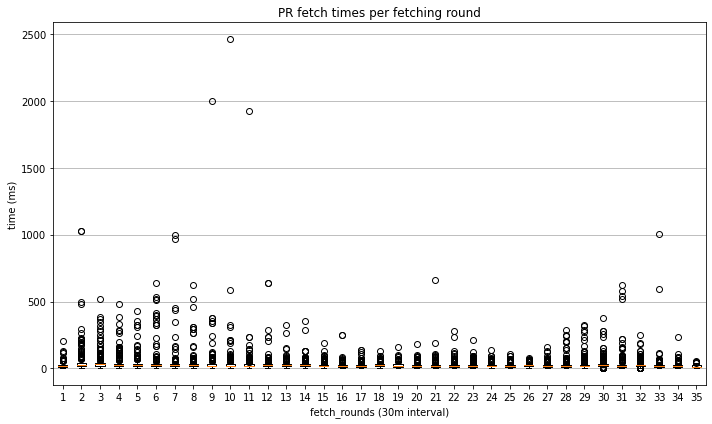

In [16]:
# Get the time to ping PR Holders

# Get the number of rounds that we hoarded
pobj = pd.read_sql_query("select fetch_round from fetch_results group by fetch_round order by fetch_round ASC", db_con)

fetch_time_dist = []
# Get the distribution for each of the rounds
for i, row in pobj.iterrows():
    fpd_round_ftime = pd.read_sql_query(f'select fetch_time from fetch_results where fetch_round={row["fetch_round"]}', db_con) 
    fetch_time_dist.append(fpd_round_ftime['fetch_time'] / 1000 ) # convert to secs

# TODO: remove zeros? 
    
fig, ax = plt.subplots()
ax.boxplot(fetch_time_dist, showfliers=True) 
ax.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins?
ax.set_ylabel("time (ms)")
ax.figure.set_size_inches(10, 6)
plt.title("PR fetch times per fetching round")
plt.grid(axis='y')
plt.tight_layout()
plt.show()



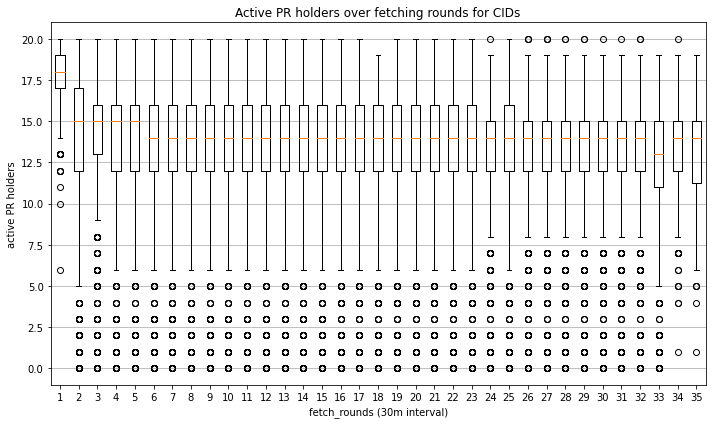

In [76]:
# Get active PR holders over fetch rounds

# Get the number of rounds that we hoarded
pobj = pd.read_sql_query("select fetch_round from fetch_results group by fetch_round order by fetch_round ASC", db_con)

succ_att_dist = []
# Get the distribution for each of the rounds
for i, row in pobj.iterrows():
    p = pd.read_sql_query(f'select success_att from fetch_results where fetch_round={row["fetch_round"]}', db_con) 
    succ_att_dist.append(p['success_att'])

fig, ax = plt.subplots()
ax.boxplot(succ_att_dist)#, showfliers=False) 
ax.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins
ax.set_ylabel("active PR holders")
ax.figure.set_size_inches(10, 6)
plt.title(f"Active PR holders over fetching rounds for CIDs")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


        client  count(client)  client percentage
0      go-ipgs          14527             72.635
1  hydra-boost           2683             13.415
2       Others           2350             11.750
3        storm            363              1.815
4          ioi             77              0.385


Text(0.5, 1.0, 'Client type on PR Holders')

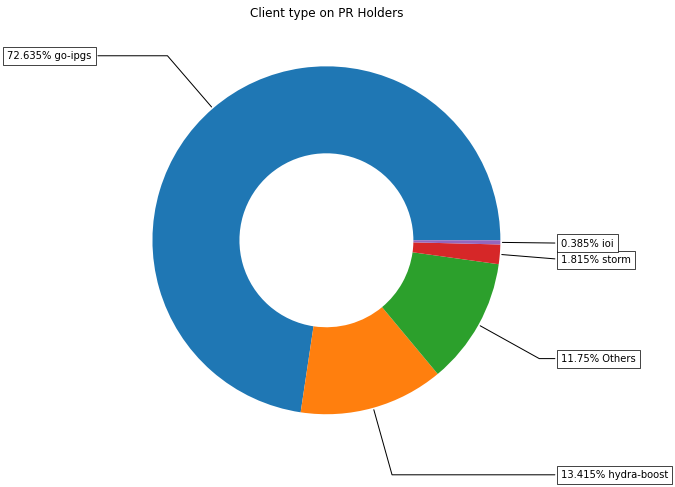

In [17]:
# Get client distribution on PR Holders
pobj = pd.read_sql_query("select client, count(client) from peer_info group by client order by count(client) DESC;", db_con)

total = 0
for i, c in pobj.iterrows():
    total += c["count(client)"]
    
# get the percentage of each client
pobj["client percentage"] = (pobj["count(client)"] * 100) / total
print(pobj)

# compose labels
labels = []
for i, row in pobj.iterrows():
    r = f'{row["client percentage"]}% {row["client"]}'
    labels.append(r)
    
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(pobj['client percentage'], wedgeprops=dict(width=0.5))#, startangle=-40)

# Generate the text boxes with the legend and percentajes 
bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Client type on PR Holders")


[72.635, 13.415, 1.815, 0.385, 11.75]


Text(0, 0.5, 'Percentage of PR Holders for a CID')

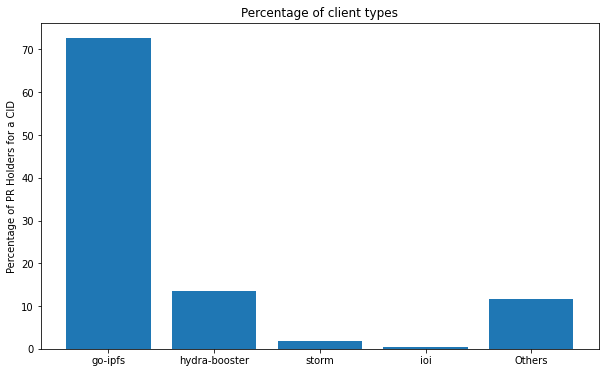

In [21]:
# Get number of Hyda boosters as PR Holders

cids = pd.read_sql_query("select id, cid_hash from cid_info", db_con)

# get the client type distribution for each of the cids
aggregations = []
for i, row in cids.iterrows():
    client_dist = {"go-ipgs": 0.0, "hydra-boost": 0.0, "storm": 0.0, "ioi": 0.0, "Others": 0.0}
    c = pd.read_sql_query(f'select client, count(client) from peer_info where cid={row["id"]} group by client order by client', db_con)

    tot = 0
    for i, r in c.iterrows():
        tot += r["count(client)"]
        
    for i, r in c.iterrows():
        client_dist[r["client"]] = (r["count(client)"] * 100) / tot 
    
    agg = []
    agg.append(client_dist["go-ipgs"])
    agg.append(client_dist["hydra-boost"])
    agg.append(client_dist["storm"])
    agg.append(client_dist["ioi"])
    agg.append(client_dist["Others"])

    aggregations.append(agg)

# Get avg of the client_dist 
aggts = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
for item in aggregations:
    aggts += np.array(item)
    
avgs = []
for item in aggts:
    avgs.append(item / len(aggregations))
    
print(avgs)

l = ["go-ipfs", "hydra-booster", "storm", "ioi", "Others"]
plt.bar(l, avgs)
plt.title("Percentage of client types")
plt.ylabel("Percentage of PR Holders for a CID") # TODO: hardcoded to 30 mins   
    